In [1]:
using DifferentialEquations
using Plots
using ForwardDiff
using NLsolve
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using DataFrames

In [2]:
# Hodgkin-Huxley parameter struct for the PDE case
mutable struct HH_PDE_Params
    gK::Float64
    gNa::Float64
    gL::Float64
    EK::Float64
    ENa::Float64
    EL::Float64 #
	V_rest::Float64
    Tfac::Float64 # temperature factor (dimensionless)
    C::Float64 # membrane capacitance [F/mm^2]
	I_base::Float64
    I_stim::Float64 # stimulation current functional (maps time to I_stim(x) over space)
	D::Float64 # Constant of the diffusivity matrix (~alpha)
	L::Float64 # Length of the cable
	N::Int64 # Discretization of the cable
end


In [3]:
temperature_factor(t) = 3^((t - 6.3) / 10)

temperature_factor (generic function with 1 method)

In [4]:
L = 10.0                # cm, cable length
N = 201                # number of grid points
dx = L/(N-1)
x = range(0, L, length=N)
D = 1.0                # seems to be a diffusivity constant.

# Hodgkin-Huxley parameters
gNa, gK, gL = 120.0, 36.0, 0.3
ENa, EK, EL = 50.0, -77.0, -54.4
C = 1.0
V_rest = -65.
T = 10.

I_stim = 200.
p = HH_PDE_Params(gK, gNa, gL, EK, ENa, EL, V_rest, temperature_factor(T), C, 0., I_stim, D, L, N)

DIRICHLET = false
NEUMANN = true

true

In [5]:
function laplacian_matrix(N, dx)
        main = -2 * ones(N)
        off = ones(N-1)
        A = spdiagm(-1 => off, 0 => main, 1 => off) 
		if DIRICHLET
        	A[1,:] .= 0;  A[end,:] .= 0    # Dirichlet: boundary rows are zero (V fixed)
		elseif NEUMANN
			A[1,1] = -1; A[end, end] = -1
		end
		A /= dx^2
        return A
end

laplacian_matrix (generic function with 1 method)

In [6]:
Δ = laplacian_matrix(N, dx)

201×201 SparseMatrixCSC{Float64, Int64} with 601 stored entries:
⎡⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

In [7]:
# Vector ODE system: [V₁..V_N, n₁..n_N, m₁..m_N, h₁..h_N]
function hh_cable!(du, u, p, t)

	# Extract quantities from the state vector
	V = @view u[1:p.N]
	n = @view u[p.N+1:2p.N]
	m = @view u[2p.N+1:3p.N]
	h = @view u[3p.N+1:4p.N]
	dV = @view du[1:p.N]
	dn = @view du[p.N+1:2p.N]
	dm = @view du[2p.N+1:3p.N]
	dh = @view du[3p.N+1:4p.N]
	
	# Laplacian for V, zero at boundaries
	diffV = p.D * (Δ * V)
	
	I_ext = zeros(N)
	stim = convert(Int, round(p.N/2)) : convert(Int, round(p.N/2 + 10))
	I_ext[stim] .= p.I_stim    # μA/cm²
	
	for i in 1:p.N
		I_Na = p.gNa * m[i]^3 * h[i] * (V[i] - p.ENa)
		I_K  = p.gK * n[i]^4 * (V[i] - p.EK)
		I_L  = p.gL * (V[i] - p.EL)
		dV[i] = (diffV[i] - I_Na - I_K - I_L + I_ext[i]) / C
		dn[i] = p.Tfac * (alpha_n(V[i]) * (1.0 - n[i]) - beta_n(V[i]) * n[i])
		dm[i] = p.Tfac * (alpha_m(V[i]) * (1.0 - m[i]) - beta_m(V[i]) * m[i])
		dh[i] = p.Tfac * (alpha_h(V[i]) * (1.0 - h[i]) - beta_h(V[i]) * h[i])
	end
	nothing
end

hh_cable! (generic function with 1 method)

In [8]:
function alpha_n(v)
    vred = v - V_rest
    A_n = exp((-vred+10.0)/10.0)
    return 0.01 * (-vred + 10.0) / (A_n - 1.0 + eps())
end

function beta_n(v)
    vred = v - V_rest
    return 0.125 * exp(-vred/80.0)
end

function alpha_m(v)
    vred = v - V_rest
    A_m = exp((-vred+25.0)/10.0)
    return 0.1 * (-vred + 25.0) / (A_m - 1.0 + eps())
end

function beta_m(v)
    vred = v - V_rest
    return 4.0 * exp(-vred/18.0)
end

function alpha_h(v)
    vred = v - V_rest
    return 0.07 * exp(-vred/20.0)
end

function beta_h(v)
    vred = v - V_rest
    B_h = exp((-vred+30.0)/10.0)
    return 1.0 / (B_h + 1.0 + eps())
end

temperature_factor(t) = 3^((t - 6.3) / 10)


temperature_factor (generic function with 1 method)

In [9]:
gK = 36.0
gNa = 120.0
gL = 0.3
EK = -77.0
ENa = 50.0
EL = -54.4
C = 1.

V_rest = -65.  # See to which value it converges

# Time span
tspan = (0.0, 20.0)

I = 40.
T = 6.3

6.3

In [10]:
temperature_factor(t) = 3^((t - 6.3) / 10)
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v))
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v))
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v))

h_inf (generic function with 1 method)

In [11]:
temp_factor = temperature_factor(T)
p = HH_PDE_Params(gK, gNa, gL, EK, ENa, EL, V_rest, temperature_factor(T), C, 0., I_stim, D, L, N)

HH_PDE_Params(36.0, 120.0, 0.3, -77.0, 50.0, -54.4, -65.0, 1.0, 1.0, 0.0, 200.0, 1.0, 10.0, 201)

In [12]:
# For initial condition: Find Stationary State (no stimulation) with NLsolve
function hh_stat!(u::AbstractVector{T}, p::HH_PDE_Params) where T
    v, n, m, h = u
    dv = (-(p.gK * n^4 * (v - p.EK)) -
             (p.gNa * m^3 * h * (v - p.ENa)) -
             (p.gL * (v - p.EL)) +
             p.I_stim*0 + p.I_base) / p.C
    dn = p.Tfac * (alpha_n(v) * (1.0 - n) - beta_n(v) * n)
    dm = p.Tfac * (alpha_m(v) * (1.0 - m) - beta_m(v) * m)
    dh = p.Tfac * (alpha_h(v) * (1.0 - h) - beta_h(v) * h)
    return [dv, dn, dm, dh]
end

hh_stat! (generic function with 1 method)

In [13]:
function find_fixpoint(p)
	u0_guess = [V_rest*1., n_inf(V_rest), m_inf(V_rest), h_inf(V_rest)]
	sol_stat = nlsolve(u -> hh_stat!(u, p), u0_guess, autodiff=:forward, xtol=1e-3)
	u0 = sol_stat.zero
	return u0
end

find_fixpoint (generic function with 1 method)

In [14]:
u0_guess = [V_rest, n_inf(V_rest), m_inf(V_rest), h_inf(V_rest)]
sol_stat = nlsolve(u -> hh_stat!(u, p), u0_guess, autodiff=:forward)
u0_0D = sol_stat.zero
V0 = u0_0D[1] * ones(N)
n0 = u0_0D[2] * ones(N)
m0 = u0_0D[3] * ones(N)
h0 = u0_0D[4] * ones(N)
@show u0_0D
u0 = vcat(V0, n0, m0, h0)
	

u0_0D = [-64.9997224275332, 0.3176811676662185, 0.052934217634013014, 0.5961110461633801]


804-element Vector{Float64}:
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
 -64.9997224275332
   ⋮
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801
   0.5961110461633801

In [15]:
# Define the problem
probPDE = ODEProblem(hh_cable!, u0, tspan, p);



In [16]:
algos = [
	# implicit
	TRBDF2(),         # stiff trapez. BDF
	#Rosenbrock23(),   # Rosenbrock 2/3

	# explicit
	#RK4(), # standard Runge Kutta 4
    Tsit5(),          #  RK 5
	#Vern6(), # higher-order explicit RK
	#Vern7(),          
	#Vern8(),
    VCABM(),    # VCABM (adaptive order adaptive time Adams Moulton method)
	AutoTsit5(Rosenbrock23()) # auto switching impl/expl
]

4-element Vector{OrdinaryDiffEqCore.OrdinaryDiffEqAlgorithm}:
 TRBDF2(; linsolve = nothing, nlsolve = NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}(1//100, 10, 1//5, 1//5, false, true, 0//1), precs = DEFAULT_PRECS, smooth_est = true, extrapolant = linear, controller = PI, step_limiter! = trivial_limiter!, autodiff = AutoForwardDiff(),)
 Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
 VCABM(; thread = static(false),)
 CompositeAlgorithm(; algs = (Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), Rosenbrock23{0, AutoForwardDiff{nothing, Nothing}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}(nothing, OrdinaryDiffEqCore.DEFAULT_PREC

In [17]:
abstols = 10.0 .^ (-4:-3:-8) # da nur testweise, abstol=reltol

2-element Vector{Float64}:
 0.0001
 1.0e-7

In [18]:
results = DataFrame(
    algo      = String[],
	tol    = Float64[],
	h = Float64[],
    median_ns = Float64[],
    mean_ns   = Float64[],
    std_ns    = Float64[],
    allocs    = Int[],
    bytes     = Int[],
);

In [19]:
stepsize_plot = plot(
    layout = (length(abstols), 1),
	background_color_legend = nothing,
    sharex = true
);

In [ ]:

for (i, abstol) in enumerate(abstols)
    reltol = abstol   
	for alg in algos
		name_alg = string(nameof(typeof(alg)))
	    @info ("benchmark ", name_alg, " at abstol = ", abstol)
	
	    trial = @benchmark solve($probPDE, $alg;
	                             abstol = $abstol,
	                             reltol = $reltol,
	                             save_everystep = true) seconds=10
		sol = solve(
			probPDE, 
			alg; 
			abstol = abstol, 
			reltol = reltol, 
			save_everystep = true,
			dt=sqrt(abstol) # emprical guess
		)
	
		@info trial
		push!(results, (
		    name_alg,
			abstol,
			0.,
		    median(trial).time,     # median runtime (ns)
		    mean(trial).time,       # mean runtime (ns)
		    0.,#std(trial).time,        # std dev of runtime (ns)
		    trial.allocs,           # allocations per evaluation
		    trial.memory,           # bytes allocated per evaluation
		))
		
		t  = sol.t
	    Δt = diff(t)
	
        plot!(stepsize_plot,
              t[1:end-1], Δt;
              yscale  = :log10,
              xlabel  = "t",
              ylabel  = "Δt",
              label   = name_alg,
              subplot = i)
	end
	plot!(
		stepsize_plot;
		title   = "abstol = $(abstol).3f",
		size=(800, 800 * length(abstols)),
		subplot = i
	)
end

┌ Info: ("benchmark ", "TRBDF2", " at abstol = ", 0.0001)
└ @ Main e:\Uni\RWTHCES\WPI\NeuralAnalysisJulia\notebooks\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:6


  25.052 s (719416287 allocations: 20.64 GiB)


Excessive output truncated after 10486084 bytes.

ErrorException: type Float64 has no field time

In [21]:
@info results

Könnten die impliziten Verfahren durch bessere Löser/andere Hyperparameter beschleunigt werden ?

In [22]:
markers = [:circle, :diamond, :star5, :utriangle, :x, :+, :pentagon, :rect, :cross, :dtriangle]
sort!(results, [:tol, :algo])

# Runtime
p_time = plot(
    xscale = :log10,
    yscale = :log10,
    xlabel = "tolerance",
    ylabel = "median runtime [ms]",
    title  = "Median runtime [ms] vs tolerance",
)

for (i, alg) in enumerate(algos)
	name_alg = string(nameof(typeof(alg)))
    df_alg = filter(:algo => ==(name_alg), results)
    plot!(
		p_time,
		df_alg.tol,
		df_alg.median_ns ./1000000;
		marker = markers[mod1(i, length(markers))],
		label  = name_alg,
		xflip = true
	)
		
end

# Allocations 
p_allocs = plot(
    xscale = :log10,
    yscale = :log10,
    xlabel = "tolerance",
    ylabel = "allocations per run",
    title  = "Allocations vs tolerance",
)

for (i, alg) in enumerate(algos)
	name_alg = string(nameof(typeof(alg)))
    df_alg = filter(:algo => ==(name_alg), results)
    plot!(
		p_allocs,
		df_alg.tol,
		df_alg.allocs;
		marker = markers[mod1(i, length(markers))],
		label  = name_alg,
		xflip = true
	)
end

# Bytes
p_bytes = plot(
	xscale = :log10,
	yscale = :log10,
	xlabel = "tolerance",
	ylabel = "bytes per run",
	title  = "Allocated bytes vs tolerance",
)

for (i, alg) in enumerate(algos)
	name_alg = string(nameof(typeof(alg)))
	df_alg = filter(:algo => ==(name_alg), results)
	plot!(
		p_bytes,
		df_alg.tol,
		df_alg.bytes;
		marker = markers[mod1(i, length(markers))],
		label  = name_alg,
		xflip = true
	)
end



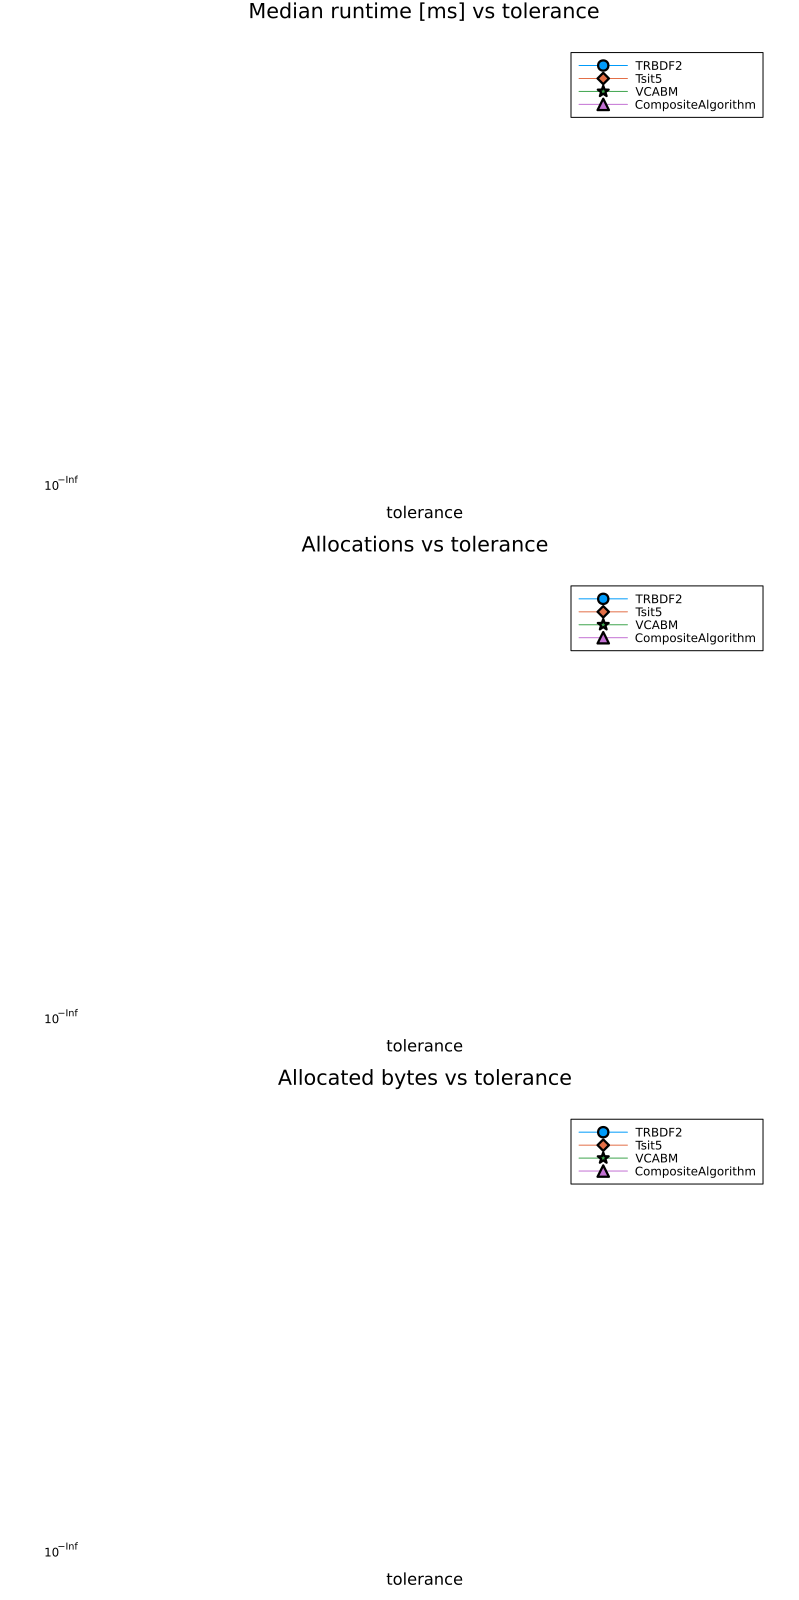

In [23]:
plot(p_time, p_allocs, p_bytes; layout = (3, 1), legend = :best, size=(800,1600),background_color_legend = nothing)

"Reference solution"

In [24]:
sol = solve(probPDE, TRBDF2(), abstol=10e-12, reltol=10e-8)

retcode: Success
Interpolation: 3rd order Hermite
t: 803-element Vector{Float64}:
  0.0
  3.376378230991923e-6
  3.714016054091115e-5
  0.00037477798364010336
  0.0015464242088776322
  0.002718070434115161
  0.006371158258328661
  0.009315560441385878
  0.01757316074141086
  0.022894955677709564
  ⋮
 19.555148163613964
 19.61839013275791
 19.683238146902163
 19.748086161046416
 19.80613471088364
 19.86508700246996
 19.92403929405628
 19.982991585642598
 20.0
u: 803-element Vector{Vector{Float64}}:
 [-64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332, -64.9997224275332  …  0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801, 0.5961110461633801]
 [-64.99972242753324, -64.99972242753324, -64.99972242753324, -64.99972242753324, -64.99972242753324, 

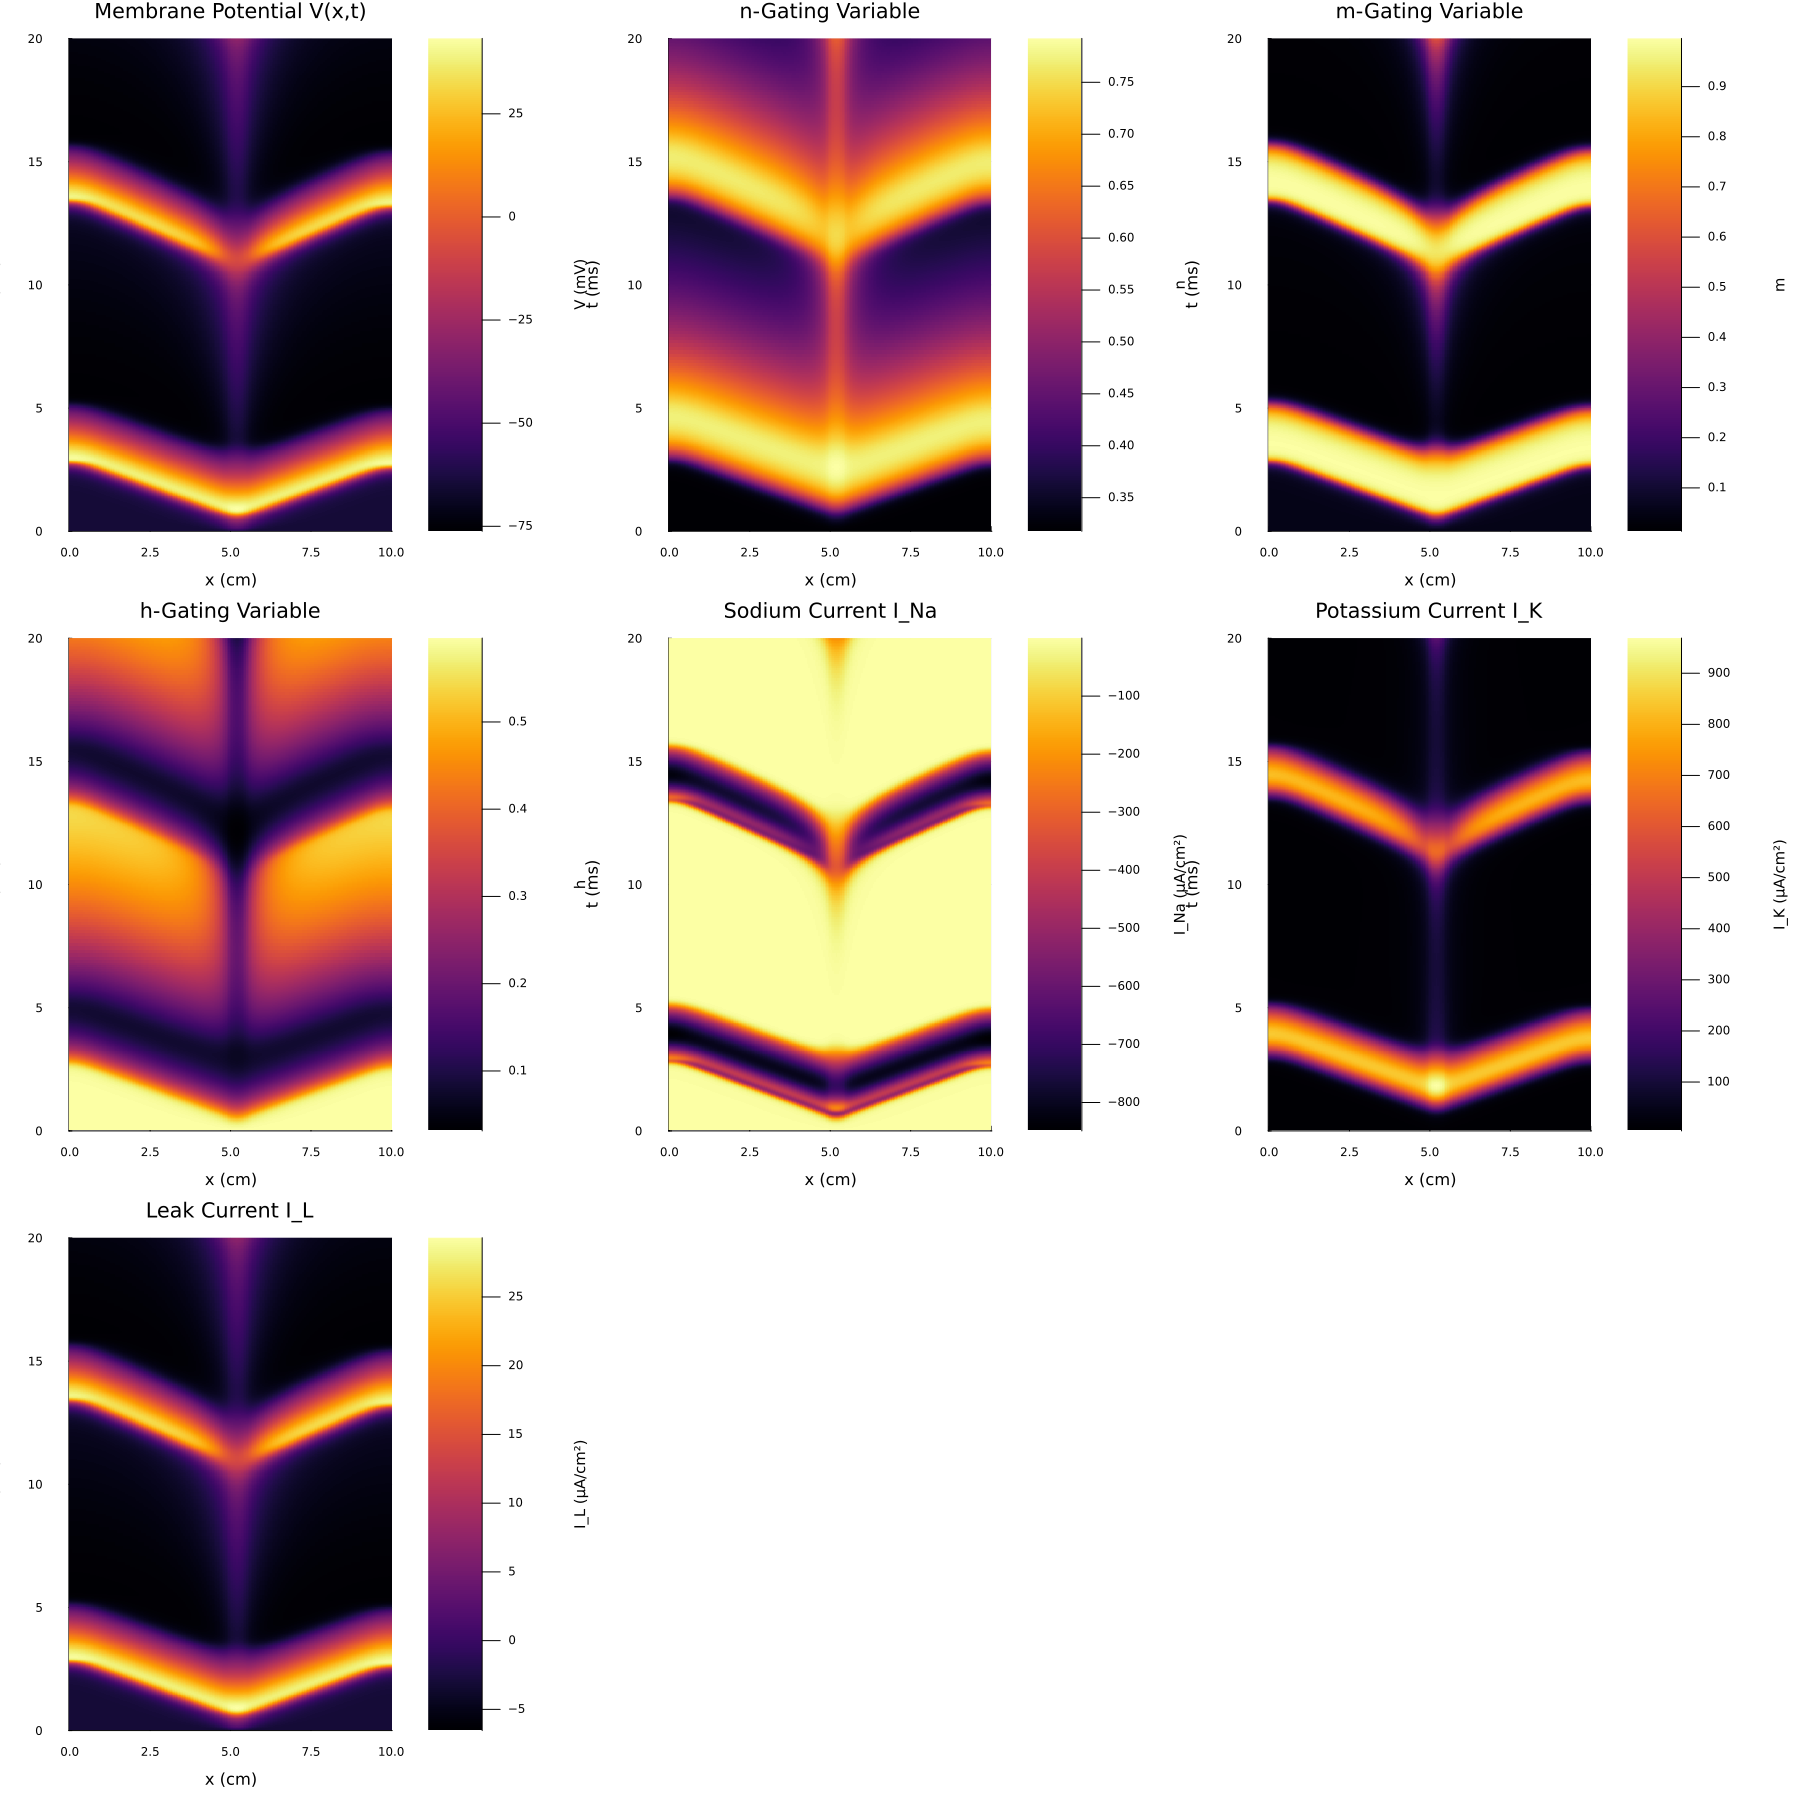

In [25]:
Nt = length(sol.t)
Nspace = N

Vmat = zeros(Nt, Nspace)
nmat = zeros(Nt, Nspace)
mmat = zeros(Nt, Nspace)
hmat = zeros(Nt, Nspace)

INa_mat = zeros(Nt, Nspace)
IK_mat  = zeros(Nt, Nspace)
IL_mat  = zeros(Nt, Nspace)

for i in 1:Nt
    u = sol[i]
    V = @view u[1:Nspace]
    n = @view u[Nspace+1 : 2Nspace]
    m = @view u[2Nspace+1 : 3Nspace]
    h = @view u[3Nspace+1 : 4Nspace]

    Vmat[i, :] = V
    nmat[i, :] = n
    mmat[i, :] = m
    hmat[i, :] = h

    @inbounds for j in 1:Nspace
        INa_mat[i,j] = gNa * m[j]^3 * h[j] * (V[j] - ENa)
        IK_mat[i,j]  = gK  * n[j]^4       * (V[j] - EK)
        IL_mat[i,j]  = gL  * (V[j] - EL)
    end
end

# Potential and gating variable heatmaps
pV = heatmap(x, sol.t, Vmat, xlabel="x (cm)", ylabel="t (ms)", colorbar_title="V (mV)",
             title="Membrane Potential V(x,t)")
pn = heatmap(x, sol.t, nmat, xlabel="x (cm)", ylabel="t (ms)", colorbar_title="n",
             title="n-Gating Variable")
pm = heatmap(x, sol.t, mmat, xlabel="x (cm)", ylabel="t (ms)", colorbar_title="m",
             title="m-Gating Variable")
ph = heatmap(x, sol.t, hmat, xlabel="x (cm)", ylabel="t (ms)", colorbar_title="h",
             title="h-Gating Variable")

# Current heatmaps
pNa = heatmap(x, sol.t, INa_mat, xlabel="x (cm)", ylabel="t (ms)", colorbar_title="I_Na (μA/cm²)",
              title="Sodium Current I_Na")
pK  = heatmap(x, sol.t, IK_mat,  xlabel="x (cm)", ylabel="t (ms)", colorbar_title="I_K (μA/cm²)",
              title="Potassium Current I_K")
pL  = heatmap(x, sol.t, IL_mat,  xlabel="x (cm)", ylabel="t (ms)", colorbar_title="I_L (μA/cm²)",
              title="Leak Current I_L")

# Arrange into 3x2 layout
plot(pV, pn, pm, ph, pNa, pK, pL, layout=(3,3), size=(1800, 1800))
